In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import sys
import os.path
from run_multi import run_multiple
sys.path.append(
    os.path.abspath(os.path.dirname(os.path.abspath(''))))

from simulation import Parameters
from equations import solveDiscrete, decayLengthPhysical, get_kd, get_v
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import os

dat, norm, colorcoded, colorcodedlabel, x, t, mt_length = run_multiple()

1 diff: 0.093  off from steady state: 2.8685023624717804e-07 error in decay length: 0.004350121016780006
2 diff: 0.093  off from steady state: -9.416076934127504e-10 error in decay length: 0.00450924561458077
3 diff: 0.093  off from steady state: -1.6091899071797307e-11 error in decay length: 0.0045689831735716835
4 diff: 0.093  off from steady state: 1.3621694122400451e-09 error in decay length: 0.004599992123976937
5 diff: 0.093  off from steady state: 1.4747102858572731e-06 error in decay length: 0.003544210741509457
6 diff: 0.093  off from steady state: -5.119546360504858e-09 error in decay length: 0.004121501503101754
7 diff: 0.093  off from steady state: 2.3518890298104626e-09 error in decay length: 0.004375355481393006
8 diff: 0.093  off from steady state: -6.101647714450199e-09 error in decay length: 0.004518010624796565
9 diff: 0.093  off from steady state: 4.527730596381381e-06 error in decay length: 0.002867623568540534
10 diff: 0.093  off from steady state: 4.57863428141218

In [2]:
import dill
# dill.load_session('notebook_env.db')

dill.dump_session('v8.db')
try:
    os.mkdir("figs")
except:
    ""

In [12]:
font = {'size'   : 18}

matplotlib.rc('font', **font)
   
cmap = cm.gist_ncar
colors = cm.ScalarMappable(norm=norm, cmap=cmap)

def setMarker(val, permitted_values):
    if val == permitted_values[0]:
        return '^'
    elif val == permitted_values[1]:
        return 'o'
    elif val == permitted_values[2]:
        return 'x'
    elif val == permitted_values[3]:
        return '>'
    
def mscatter(x,y,ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

def df(plotdic, key):
    if isinstance(plotdic[0][key], float) or isinstance(plotdic[0][key], int):
        return np.array([dic[key] for dic in plotdic])
    else:
        return np.array([dic[key][-1] for dic in plotdic])
    
def standard_plot(plotdat, xkey, ykey):
    plt.figure(figsize=(5,5))
    unique_vals = list(set([dic['D'] + dic['koff'] for dic in plotdat]))
    color = df(plotdat,colorcoded)
    mscatter(df(plotdat,xkey),
         df(plotdat,ykey), 
         c=color,
         m=[setMarker(dic['D'] + dic['koff'], unique_vals) for dic in plotdat],
         s=200, facecolors='none', alpha=0.6, norm=norm, cmap=cmap, label=color)
    matplotlib.pyplot.colorbar(colors, label = colorcodedlabel)

# colors = list(set(df(plotdat,'omega')))

def saveallfigs(name):
    plt.savefig(name + ".svg", transparent=True)
    plt.savefig(name + ".png", transparent=True, bbox_inches='tight')

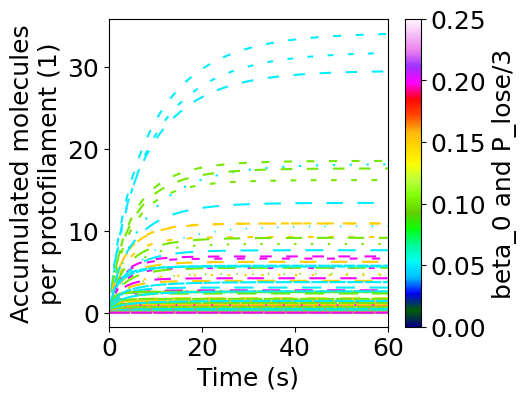

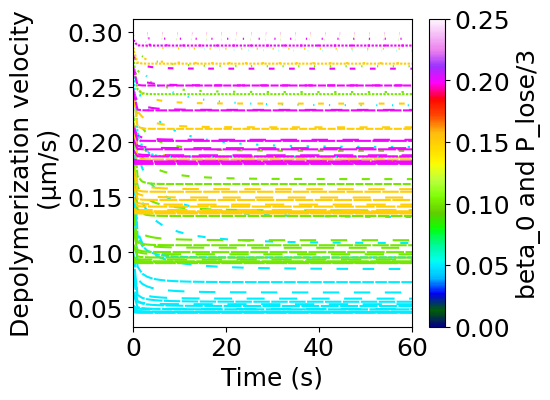

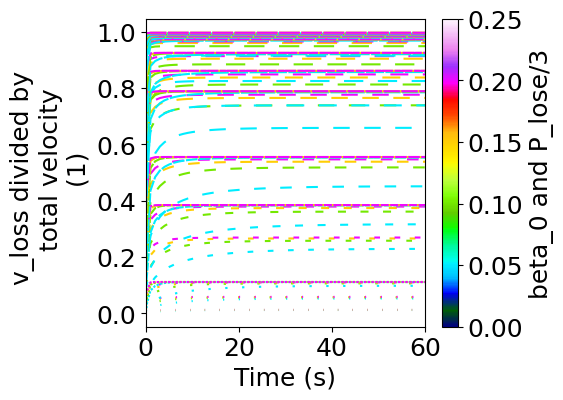

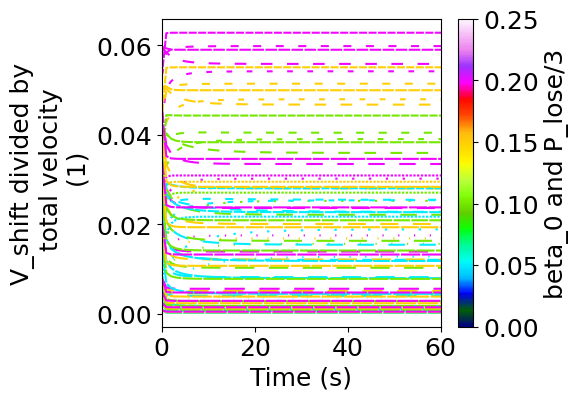

In [14]:
# filtered = list(filter(lambda condition: condition['D'] == 0.0093, plotdat))
filtered = dat#list(filter(lambda condition: 0.1 > condition['alpha'] > 0.05 and condition['D'] == 0.093, plotdat))

plt.figure(figsize=(4.5,4))
for curve in filtered:
    accumulation = curve["accumulation"]
    dash = [curve["alpha"]*10, curve["D"]*75]
    plt.plot(t,accumulation, dashes = dash, color = colors.to_rgba(curve[colorcoded]))
    
plt.xlabel("Time (s)")
plt.ylabel("Accumulated molecules\nper protofilament (1)")
plt.colorbar(colors, ax = plt.gca(), label = colorcodedlabel)
plt.xlim([0, 60])
saveallfigs("figs/time vs accumulation")

plt.figure(figsize=(4.5,4))
for curve in filtered:
    v = curve["v"]
    dash = [curve["alpha"]*10, curve["D"]*75]
    plt.plot(t,v, dashes = dash, color = colors.to_rgba(curve[colorcoded]))
plt.xlabel("Time (s)")
plt.ylabel("Depolymerization velocity\n (\u03bcm/s)")
plt.colorbar(colors, ax = plt.gca(), label = colorcodedlabel)
plt.xlim([0, 60])
saveallfigs("figs/time vs speed")

plt.figure(figsize=(4.5,4))
for curve in filtered:
    v = curve["v_lose"] / curve["v"] 
    dash = [curve["alpha"]*10, curve["D"]*75]
    plt.plot(t,v, dashes = dash, color = colors.to_rgba(curve[colorcoded]))
plt.xlabel("Time (s)")
plt.ylabel("v_loss divided by \n total velocity\n (1)")
plt.colorbar(colors, ax = plt.gca(), label = colorcodedlabel)
plt.xlim([0, 60])
saveallfigs("figs/time vs v_loss  divided by v")
# plt.ylim([0, 5])
# saveallfigs("figs/time vs v_loss/v")

plt.figure(figsize=(4.5,4))
for curve in filtered:
    v = curve["v_shift"] / curve["v"] 
    dash = [curve["alpha"]*10, curve["D"]*75]
    plt.plot(t,v, dashes = dash, color = colors.to_rgba(curve[colorcoded]))
plt.xlabel("Time (s)")
plt.ylabel("V_shift divided by\n total velocity\n (1)")
plt.colorbar(colors, ax = plt.gca(), label = colorcodedlabel)
plt.xlim([0, 60])
saveallfigs("figs/time vs v_shift divided by v")
# plt.ylim([0, 5])
# saveallfigs("figs/time vs velocity divided by v_shift closeup")

C:\Users\Marcel\AppData\Local\Temp\ipykernel_10340\1156435926.py:50: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  matplotlib.pyplot.colorbar(colors, label = colorcodedlabel)


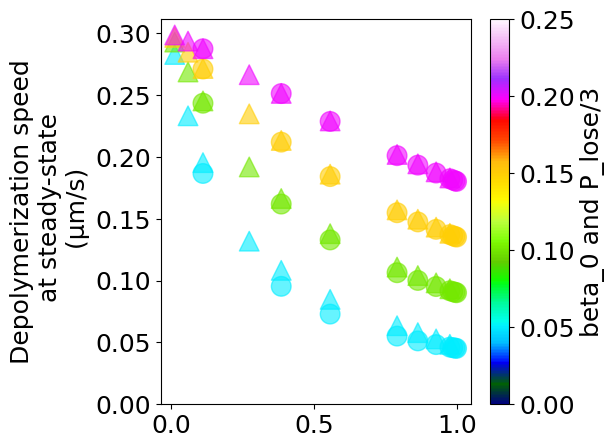

In [15]:
plotdat = dat
fig = standard_plot(plotdat, 'alpha', 'v')
plt.ylabel("Depolymerization speed\n at steady-state\n (\u03bcm/s)")
plt.ylim(0)
saveallfigs("figs/ase1 density vs depolymerization speed")

C:\Users\Marcel\AppData\Local\Temp\ipykernel_10340\1156435926.py:50: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  matplotlib.pyplot.colorbar(colors, label = colorcodedlabel)


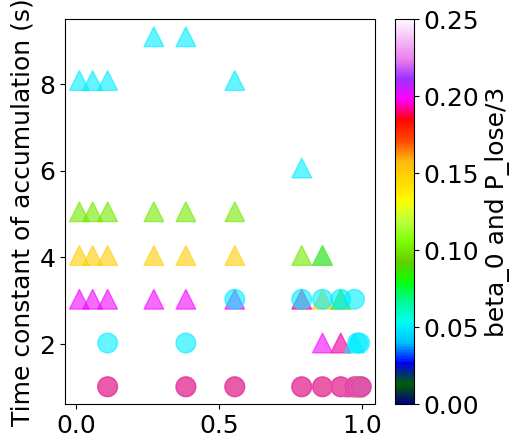

In [16]:
standard_plot(plotdat, 'alpha', 't_const')
plt.ylabel('Time constant of accumulation (s)')
# plt.xlabel("Ase1 density (1/protofilament dimer)")
# plt.ylim([0,25])
saveallfigs("figs/ase1 density vs time constant of accumulation ")

C:\Users\Marcel\AppData\Local\Temp\ipykernel_10340\1156435926.py:50: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  matplotlib.pyplot.colorbar(colors, label = colorcodedlabel)


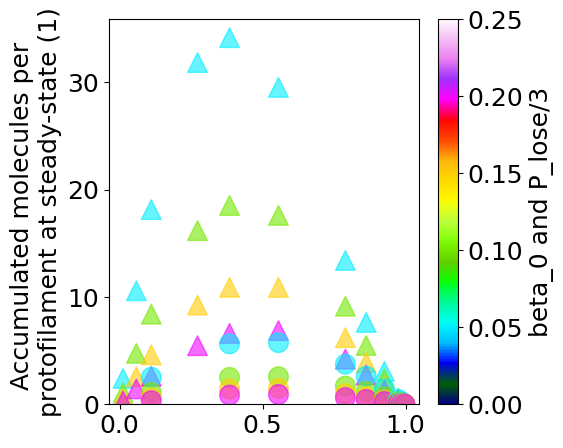

In [17]:
standard_plot(plotdat, 'alpha', 'accumulation')
plt.ylabel("Accumulated molecules per \nprotofilament at steady-state (1)")
# plt.xlabel("Ase1 density (1/protofilament dimer)")
plt.ylim(0)
saveallfigs("figs/ase1 density vs accumulated molecules")


C:\Users\Marcel\AppData\Local\Temp\ipykernel_10340\1156435926.py:50: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  matplotlib.pyplot.colorbar(colors, label = colorcodedlabel)


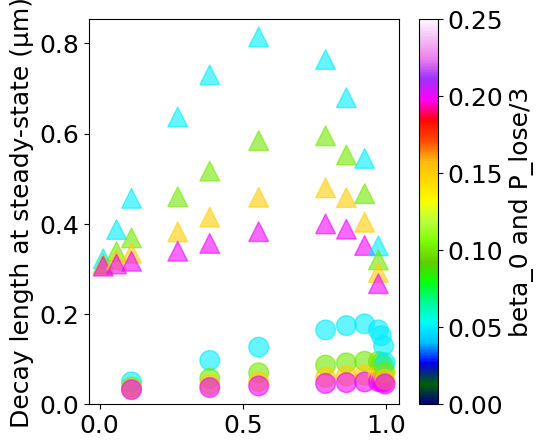

In [18]:
standard_plot(plotdat, 'alpha', 'decay_length')

plt.ylabel("Decay length at steady-state (\u03bcm)")
# plt.xlabel("Ase1 density (1/protofilament dimer)")
plt.ylim(0)
saveallfigs("figs/ase1 density vs decay length")


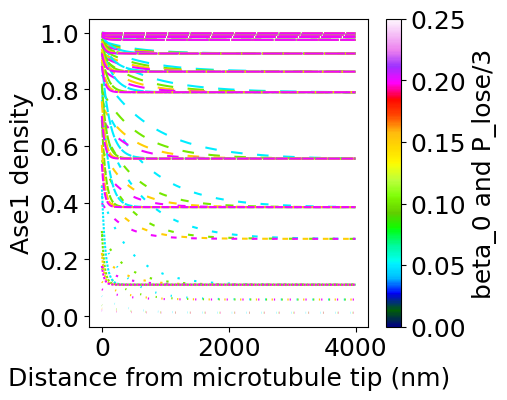

In [19]:
# filtered = list(filter(lambda condition: 0.1 > condition['alpha'] > 0.05 and condition['D'] == 0.093, plotdat))
plot = plt.figure(figsize=(4.5,4))
for curve in dat:
    solution = curve["solution"]
    y = solution[-1][:]
    dash = [curve["alpha"]*10, curve["D"]*75]
    plt.plot(x*1000,y, dashes = dash, color = colors.to_rgba(curve[colorcoded][-1] if hasattr(curve[colorcoded], "__len__") else curve[colorcoded]))

plt.xlabel("Distance from microtubule tip (nm)")
plt.ylabel("Ase1 density")
plt.colorbar(colors, ax = plt.gca(), label = colorcodedlabel)
saveallfigs("figs/distance versus Ase1 density")